# Building a Beer Recommendation System

#### I. Cleaning and preparing the data

#### II. Predicting the beer clusters with unsupervized learning using KMeans Clustering

#### III. Building the recommender

### Importing libraries and modules

In [89]:
import pandas as pd
import numpy as np
import string 
from itertools import permutations

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import silhouette_score
from sklearn.metrics import classification_report
from scipy.spatial import distance_matrix
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt 
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer

import warnings

warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

#### Importing the data

In [2]:
data = pd.read_csv('data.csv')

## I. Cleaning and preparing the data

#### Useful functions

In [3]:
# I will use this function to scale the data with StandardScaler
def standard_scaling(df):
    transformer = StandardScaler().fit(df)
    x_standardized = transformer.transform(df)
    X = pd.DataFrame(x_standardized)
    X.columns = df.columns
    return X

### Numerical Data

#### Creating a `weighted_rating` feature

This column will be used by the recommender to rank the beers with the highest review while taking into account the number of reviews left.

In [4]:
avg_review = data['review_overall'].mean()
avg_review_nb = data['number_of_reviews'].mean()
nb_review = data['number_of_reviews']
review = data['review_overall']

data['weighted_rating'] = ((review*nb_review) + (avg_review*avg_review_nb)) / (nb_review + avg_review_nb)
data[['review_overall', 'number_of_reviews', 'weighted_rating']]

,review_overall,number_of_reviews,weighted_rating
0,3.847082,497,3.815278
1,4.034304,481,3.940641
2,3.830239,377,3.798620
3,4.005435,368,3.905371
4,3.817708,96,3.767984
...,...,...,...
3192,4.000000,4,3.751778
3193,3.730000,50,3.744429
3194,3.711538,26,3.743914
3195,3.879310,87,3.783320


### Categorical Data

#### `style` feature

This column will be the most useful to ask for user inputs when building the recommender, so it will be useful to parse and order the information that is only in one column

I want to create two new columns, one with the main style and one with the substyle, then try using the `main_style` for clustering to compare the performance with the original `style`.

In [5]:
# getting the style values by alphabetical order
styles_list = []

for letter in list(string.ascii_uppercase):
    styles_list.append([x for x in list(data['style'].unique()) if x.startswith(letter)])

styles_list = [x for x in styles_list if x != []]

# Creating a copy
df_style = data.copy()

# Looking for the values that don't have the separator '-'
for value in df_style['style']:
    if len(value.split()) == 1:
        df_style['style'] = df_style['style'].replace(value, f'{value} - {value}')
        
# modifying the values that don't have a separator to become 'value - value' so that I can split the column into two
for value in df_style['style']:
    if '-' not in value:
        df_style['style'] = df_style['style'].replace(value, f'{value} - {value}')
        
# splitting the column using '-'
df_style[['main_style','substyle']] = df_style['style'].str.split('-', expand=True)

# Cleaning the columns' values
df_style['main_style'] = df_style['main_style'].str.strip()
df_style['substyle'] = df_style['substyle'].str.strip()

# checking for NaNs
#print(df_style.isna().sum())

# first look
df_style.head()

,name,style,brewery,beer_name_(full),description,abv,min_ibu,max_ibu,astringency,body,...,malty,review_aroma,review_appearance,review_palate,review_taste,review_overall,number_of_reviews,weighted_rating,main_style,substyle
0,Amber,Altbier - Altbier,Alaskan Brewing Co.,Alaskan Brewing Co. Alaskan Amber,"Notes:Richly malty and long on the palate, wit...",5.3,25,50,13,32,...,111,3.498994,3.636821,3.556338,3.643863,3.847082,497,3.815278,Altbier,Altbier
1,Double Bag,Altbier - Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Double Bag,"Notes:This malty, full-bodied double alt is al...",7.2,25,50,12,57,...,84,3.798337,3.846154,3.904366,4.024948,4.034304,481,3.940641,Altbier,Altbier
2,Long Trail Ale,Altbier - Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Long Trail Ale,Notes:Long Trail Ale is a full-bodied amber al...,5.0,25,50,14,37,...,62,3.409814,3.667109,3.600796,3.631300,3.830239,377,3.798620,Altbier,Altbier
3,Doppelsticke,Altbier - Altbier,Uerige Obergärige Hausbrauerei GmbH / Zum Uerige,Uerige Obergärige Hausbrauerei GmbH / Zum Ueri...,Notes:,8.5,25,50,13,55,...,119,4.148098,4.033967,4.150815,4.205163,4.005435,368,3.905371,Altbier,Altbier
4,Sleigh'r Dark Doüble Alt Ale,Altbier - Altbier,Ninkasi Brewing Company,Ninkasi Brewing Company Sleigh'r Dark Doüble A...,Notes:Called 'Dark Double Alt' on the label.Se...,7.2,25,50,25,51,...,95,3.625000,3.973958,3.734375,3.765625,3.817708,96,3.767984,Altbier,Altbier


### Feature engineering

#### Adding more details to the style columns
The `style` column was separated into two because there was a lot of information in one column which gave more unique values that were needed and by separting them we could have a substyle column that showed commonality with beers that were not in a same group according to the original `style` column. 

But now some beers that had a very simple `style` (one word for example) have the same information in the `substyle` column, but for some of them this can be corrected with a bit of research. This will help with the recommender as sometimes the `style` is a bit obscure for most users, having a more well-know `style` and a more precise `substyle` will help: the main `style` will be useful for all users and the `substyle` will hold more information for more knowledgeable users.

In [6]:
df_style['main_style'].unique()

array(['Altbier', 'Barleywine', 'Bitter',
       'Bière de Champagne / Bière Brut', 'Blonde Ale', 'Bock', 'Braggot',
       'Brett Beer', 'Brown Ale', 'California Common / Steam Beer',
       'Chile Beer', 'Cream Ale', 'Dubbel', 'Farmhouse Ale',
       'Fruit and Field Beer', 'Gruit / Ancient Herbed Ale', 'Happoshu',
       'Herb and Spice Beer', 'IPA', 'Kvass', 'Kölsch', 'Lager', 'Lambic',
       'Low Alcohol Beer', 'Mild Ale', 'Old Ale', 'Pale Ale', 'Pilsner',
       'Porter', 'Pumpkin Beer', 'Quadrupel (Quad)', 'Red Ale',
       'Rye Beer', 'Scotch Ale / Wee Heavy', 'Scottish Ale',
       'Smoked Beer', 'Sour', 'Stout', 'Strong Ale', 'Tripel',
       'Wheat Beer', 'Wild Ale', 'Winter Warmer'], dtype=object)

In [7]:
df_style['substyle'].unique()

array(['Altbier', 'American', 'English',
       'English Extra Special / Strong Bitter (ESB)',
       'Bière de Champagne / Bière Brut', 'Belgian', 'Doppelbock',
       'Eisbock', 'Maibock', 'Traditional', 'Weizenbock', 'Braggot',
       'Brett Beer', 'Belgian Dark', 'California Common / Steam Beer',
       'Chile Beer', 'Cream Ale', 'Dubbel', 'Bière de Garde', 'Sahti',
       'Saison', 'Fruit and Field Beer', 'Gruit / Ancient Herbed Ale',
       'Happoshu', 'Herb and Spice Beer', 'Black / Cascadian Dark Ale',
       'Imperial', 'New England', 'Kvass', 'Kölsch', 'Adjunct',
       'American Amber / Red', 'European / Dortmunder Export',
       'European Dark', 'European Pale', 'European Strong', 'Helles',
       'India Pale Lager (IPL)', 'Japanese Rice',
       'Kellerbier / Zwickelbier', 'Light', 'Malt Liquor',
       'Munich Dunkel', 'Märzen / Oktoberfest', 'Rauchbier',
       'Schwarzbier', 'Vienna', 'Faro', 'Fruit', 'Gueuze',
       'Low Alcohol Beer', 'English Dark', 'English Pale',

In [8]:
# cleaning Altbier - it is a kind of Brown Ale, so we'll put Brown Ale as main style and Altbier as `substyle`
####
for value in df_style['main_style']:
    if value == 'Altbier':
        df_style['main_style'] = df_style['main_style'].replace(value, 'Brown Ale')

# cleaning Braggot - it's a kind of Mead so we'll put Mead in style and keep Braggot in the `substyle`
for value in df_style['main_style']:
    if value == 'Braggot':
        df_style['main_style'] = df_style['main_style'].replace(value, 'Mead')
        
# cleaning Brett - all of the Brett Beers are from American breweries, so the `substyle` will be changed to American
for value in df_style['substyle']:
    if value == 'Brett Beer':
        df_style['substyle'] = df_style['substyle'].replace(value, 'American')
        
# cleaning Brett - all of the Brett Beers are from American breweries, so the `substyle` will be changed to American
for value in df_style['substyle']:
    if value == 'Brett Beer':
        df_style['substyle'] = df_style['substyle'].replace(value, 'American')
        
# cleaning Dubbel - it's a kind of Belgian Trappist beer
for value in df_style['substyle']:
    if value == 'Dubbel':
        df_style['substyle'] = df_style['substyle'].replace(value, 'Belgian Trappist')

# cleaning Quadrupel (Quad) - it's a kind of Belgian Trappist beer
for value in df_style['substyle']:
    if value == 'Quadrupel (Quad)':
        df_style['substyle'] = df_style['substyle'].replace(value, 'Belgian Trappist')
        
# cleaning Tripel - it's a kind of Belgian Trappist beer
for value in df_style['substyle']:
    if value == 'Tripel':
        df_style['substyle'] = df_style['substyle'].replace(value, 'Belgian Trappist')

# cleaning Gruit / Ancient Herbed Ale - it's one of two herbal beers, so `substyle` will be changed to Herbal
for value in df_style['substyle']:
    if value == 'Gruit / Ancient Herbed Ale':
        df_style['substyle'] = df_style['substyle'].replace(value, 'Herbal')
        
# cleaning Herb and Spice Beer - it's one of two herbal beers, so `substyle` will be changed to Herbal
for value in df_style['substyle']:
    if value == 'Herb and Spice Beer':
        df_style['substyle'] = df_style['substyle'].replace(value, 'Herbal')
        
# cleaning Happoshu - it's a Japanese beer, so `substyle` will be changed to Japanese
for value in df_style['substyle']:
    if value == 'Happoshu':
        df_style['substyle'] = df_style['substyle'].replace(value, 'Japanese')

# cleaning Pumpkin Beer - it's one of two seasonal beers, so `substyle` will be changed to Seasonal
for value in df_style['substyle']:
    if value == 'Pumpkin Beer':
        df_style['substyle'] = df_style['substyle'].replace(value, 'Seasonal')
        
# cleaning Winter Warmer - it's one of two seasonal beers, so `substyle` will be changed to Seasonal
for value in df_style['substyle']:
    if value == 'Winter Warmer':
        df_style['substyle'] = df_style['substyle'].replace(value, 'Seasonal')

# cleaning Wild Ale - these beers are from American breweries, so the `substyle` will be changed to American
for value in df_style['substyle']:
    if value == 'Wild Ale':
        df_style['substyle'] = df_style['substyle'].replace(value, 'American')   

### Preparing the data for clustering

In [9]:
# creating the dataframe with the new style columns
styles = df_style[['main_style', 'substyle']]
data_2 = data.copy()
data_2 = pd.concat([data_2, styles], axis = 1)
data_2.drop('style', axis=1, inplace=True)
data_2 = data_2.rename(columns={'main_style': 'style'})

# picking the numerical features we want to use for the recommender
features_ = ['abv', 'min_ibu', 'max_ibu', 'astringency', 'body', 'alcohol', 'bitter', 'sweet', 'sour', 
              'salty', 'fruits', 'hoppy', 'spices', 'malty']

# scaling the data
X_scaled_1 = standard_scaling(data[features_])
X_scaled_2 = standard_scaling(data_2[features_])

# encoding the categoricals
cat_1 = pd.get_dummies(data[['style']], columns=['style'], drop_first=True)
cat_2 = pd.get_dummies(data_2[['style']], columns=['style'], drop_first=True)

# resetting the index
cat_1.reset_index(drop=True, inplace=True)
cat_2.reset_index(drop=True, inplace=True)
X_scaled_1.reset_index(drop=True, inplace=True)
X_scaled_2.reset_index(drop=True, inplace=True)

# finalizing the data for clustering
X_prep_1 = pd.concat([X_scaled_1, cat_1], axis=1) # with the original style column
X_prep_2 = pd.concat([X_scaled_2, cat_2], axis=1) # with the main_style column

## II. Predicting the beer clusters with unsupervized learning using KMeans Clustering

#### Useful functions

In [10]:
def k_clustering(X_prep, df, num_clusters):
    # fitting the model to the data
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(X_prep)

    # predicting / assigning the clusters:
    clusters = kmeans.predict(X_prep)
    
    # checking the size of the clusters and the performance
    print(pd.Series(clusters).value_counts().sort_index())
    print(kmeans.inertia_)
    
    # Explore the cluster assignment in the original dataset
    results_df = pd.DataFrame(df)
    results_df["cluster"] = clusters
    results_df.head()
    
    return clusters, results_df

# choosing the best k
def best_k(X_prep, interval):
    
    #using inertia
    inertia = []

    for k in interval:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_prep)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(16,8))
    plt.plot(interval, inertia, 'o-.m')
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.xticks(np.arange(min(interval), max(interval)+1, 1.0))
    print('Elbow visualization with inertia')
    plt.show()
    print()
    
    # using Yellowbrick
    km = KMeans(random_state=42)
    visualizer = KElbowVisualizer(km, k=interval)

    visualizer.fit(X_prep)    # Fit the data to the visualizer
    print('Elbow visualization with KElbowVisualizer')
    visualizer.poof() 
    
    # using Silhouette
    
    silhouette = []

    for k in interval:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_prep)
        silhouette.append(silhouette_score(X_prep, kmeans.predict(X_prep)))

    plt.figure(figsize=(16,8))
    plt.plot(interval, silhouette, 'o-.m')
    plt.xlabel('k')
    plt.ylabel('silhouette score')
    plt.xticks(np.arange(min(interval), max(interval)+1, 1.0))
    print('Elbow visualization with Silhouette')
    plt.show()
    
    return ()

def silhouette(X_prep, k):
    
    kmeans = KMeans(n_clusters=k, random_state=42)
    plt.title('{}'.format(f'Silhouette with k = {k}'))
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    visualizer.fit(X_prep)
    
    return ()  

#### Clustering with X_prep_1 

In [11]:
clusters_1, result_df1 = k_clustering(X_prep_1, data, 6)
result_df1.head()

0    644
1    628
2    279
3    866
4    512
5    268
dtype: int64
27152.627602046974


,name,style,brewery,beer_name_(full),description,abv,min_ibu,max_ibu,astringency,body,...,spices,malty,review_aroma,review_appearance,review_palate,review_taste,review_overall,number_of_reviews,weighted_rating,cluster
0,Amber,Altbier,Alaskan Brewing Co.,Alaskan Brewing Co. Alaskan Amber,"Notes:Richly malty and long on the palate, wit...",5.3,25,50,13,32,...,8,111,3.498994,3.636821,3.556338,3.643863,3.847082,497,3.815278,1
1,Double Bag,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Double Bag,"Notes:This malty, full-bodied double alt is al...",7.2,25,50,12,57,...,12,84,3.798337,3.846154,3.904366,4.024948,4.034304,481,3.940641,1
2,Long Trail Ale,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Long Trail Ale,Notes:Long Trail Ale is a full-bodied amber al...,5.0,25,50,14,37,...,4,62,3.409814,3.667109,3.600796,3.631300,3.830239,377,3.798620,0
3,Doppelsticke,Altbier,Uerige Obergärige Hausbrauerei GmbH / Zum Uerige,Uerige Obergärige Hausbrauerei GmbH / Zum Ueri...,Notes:,8.5,25,50,13,55,...,16,119,4.148098,4.033967,4.150815,4.205163,4.005435,368,3.905371,4
4,Sleigh'r Dark Doüble Alt Ale,Altbier,Ninkasi Brewing Company,Ninkasi Brewing Company Sleigh'r Dark Doüble A...,Notes:Called 'Dark Double Alt' on the label.Se...,7.2,25,50,25,51,...,20,95,3.625000,3.973958,3.734375,3.765625,3.817708,96,3.767984,0


Elbow visualization with inertia


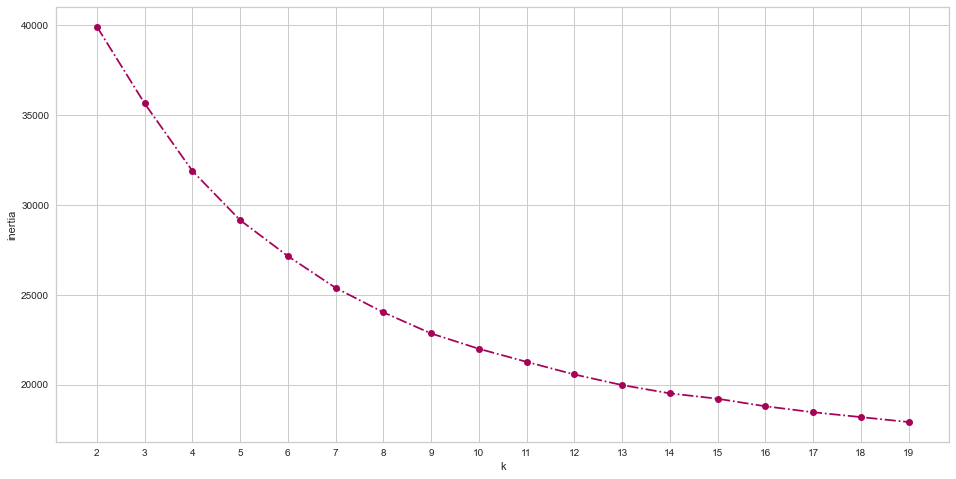


Elbow visualization with KElbowVisualizer


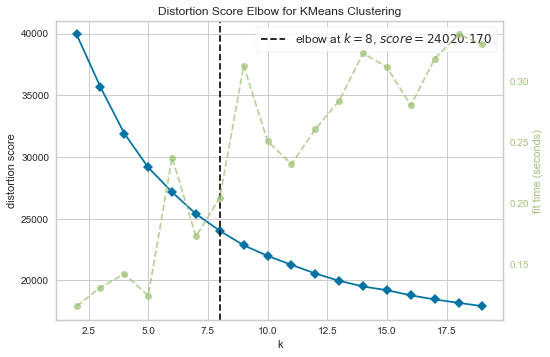

Elbow visualization with Silhouette


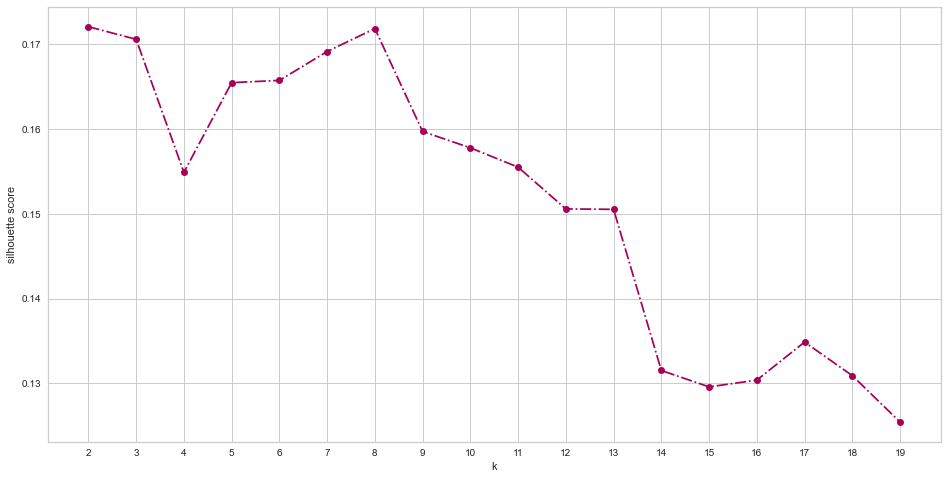

In [12]:
# searching for the best number of clusters
k_number_1 =  best_k(X_prep_1, range(2, 20))

In [13]:
# running KMeans using 7 clusters
clusters_1, result_df1 = k_clustering(X_prep_1, data, 8)
result_df1.head()

0    147
1    622
2    520
3    281
4    644
5    518
6    275
7    190
dtype: int64
24020.170081492106


,name,style,brewery,beer_name_(full),description,abv,min_ibu,max_ibu,astringency,body,...,spices,malty,review_aroma,review_appearance,review_palate,review_taste,review_overall,number_of_reviews,weighted_rating,cluster
0,Amber,Altbier,Alaskan Brewing Co.,Alaskan Brewing Co. Alaskan Amber,"Notes:Richly malty and long on the palate, wit...",5.3,25,50,13,32,...,8,111,3.498994,3.636821,3.556338,3.643863,3.847082,497,3.815278,4
1,Double Bag,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Double Bag,"Notes:This malty, full-bodied double alt is al...",7.2,25,50,12,57,...,12,84,3.798337,3.846154,3.904366,4.024948,4.034304,481,3.940641,4
2,Long Trail Ale,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Long Trail Ale,Notes:Long Trail Ale is a full-bodied amber al...,5.0,25,50,14,37,...,4,62,3.409814,3.667109,3.600796,3.631300,3.830239,377,3.798620,5
3,Doppelsticke,Altbier,Uerige Obergärige Hausbrauerei GmbH / Zum Uerige,Uerige Obergärige Hausbrauerei GmbH / Zum Ueri...,Notes:,8.5,25,50,13,55,...,16,119,4.148098,4.033967,4.150815,4.205163,4.005435,368,3.905371,4
4,Sleigh'r Dark Doüble Alt Ale,Altbier,Ninkasi Brewing Company,Ninkasi Brewing Company Sleigh'r Dark Doüble A...,Notes:Called 'Dark Double Alt' on the label.Se...,7.2,25,50,25,51,...,20,95,3.625000,3.973958,3.734375,3.765625,3.817708,96,3.767984,4


#### Visualizing the clusters sizes with Silhouette
Let's also check with k = 3 and k = 13 as they could also be a potential elbow.

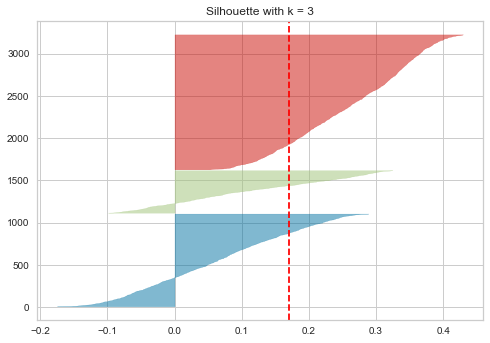

In [14]:
silhouette_viz = silhouette(X_prep_1, 3)
# 1st cluster is too big

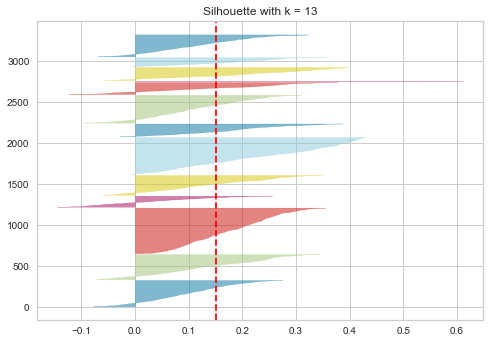

In [15]:
silhouette_viz = silhouette(X_prep_1, 13)
# some clusters are too thin

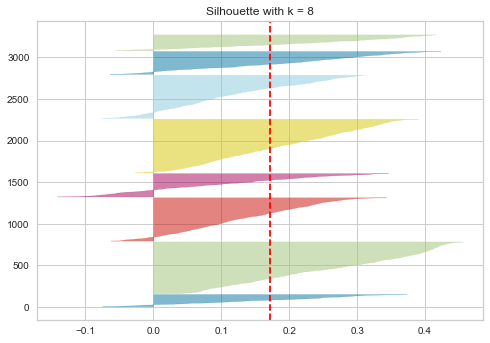

In [16]:
silhouette_viz = silhouette(X_prep_1, 8)
# this one looks more balanced

#### Visualizing the 8 clusters

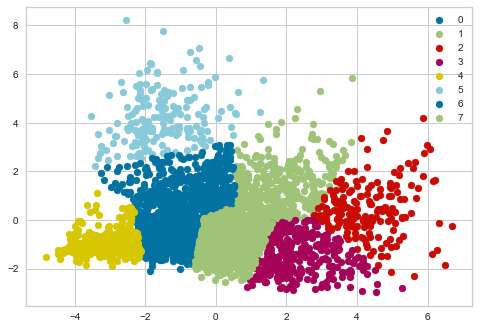

In [17]:
## Transform the data into 2D so we can see
pca = PCA(2) 
X_2D = pca.fit_transform(X_prep_1)

# Predicting the clusters with k = 8
kmeans_7 = KMeans(n_clusters=8, random_state=42)
kmeans_7.fit(X_2D)
clusters_ = kmeans_7.predict(X_2D)


labels = np.unique(clusters_)

for i in labels:
    plt.scatter(X_2D[clusters_ == i , 0] , X_2D[clusters_ == i , 1] , label = i)
plt.legend()
plt.show()

#### Clustering with X_prep_2

In [18]:
clusters_2, result_df2 = k_clustering(X_prep_2, data, 6)
result_df2.head()

0    259
1    610
2    535
3    855
4    671
5    267
dtype: int64
26785.5201686746


,name,style,brewery,beer_name_(full),description,abv,min_ibu,max_ibu,astringency,body,...,spices,malty,review_aroma,review_appearance,review_palate,review_taste,review_overall,number_of_reviews,weighted_rating,cluster
0,Amber,Altbier,Alaskan Brewing Co.,Alaskan Brewing Co. Alaskan Amber,"Notes:Richly malty and long on the palate, wit...",5.3,25,50,13,32,...,8,111,3.498994,3.636821,3.556338,3.643863,3.847082,497,3.815278,4
1,Double Bag,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Double Bag,"Notes:This malty, full-bodied double alt is al...",7.2,25,50,12,57,...,12,84,3.798337,3.846154,3.904366,4.024948,4.034304,481,3.940641,1
2,Long Trail Ale,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Long Trail Ale,Notes:Long Trail Ale is a full-bodied amber al...,5.0,25,50,14,37,...,4,62,3.409814,3.667109,3.600796,3.631300,3.830239,377,3.798620,4
3,Doppelsticke,Altbier,Uerige Obergärige Hausbrauerei GmbH / Zum Uerige,Uerige Obergärige Hausbrauerei GmbH / Zum Ueri...,Notes:,8.5,25,50,13,55,...,16,119,4.148098,4.033967,4.150815,4.205163,4.005435,368,3.905371,2
4,Sleigh'r Dark Doüble Alt Ale,Altbier,Ninkasi Brewing Company,Ninkasi Brewing Company Sleigh'r Dark Doüble A...,Notes:Called 'Dark Double Alt' on the label.Se...,7.2,25,50,25,51,...,20,95,3.625000,3.973958,3.734375,3.765625,3.817708,96,3.767984,4


Elbow visualization with inertia


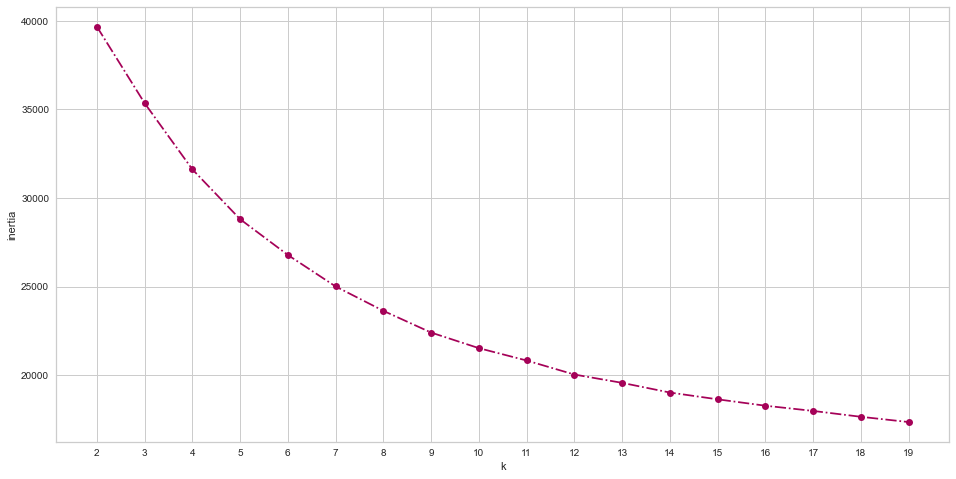


Elbow visualization with KElbowVisualizer


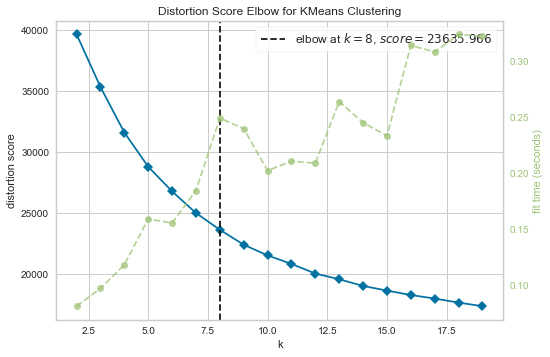

Elbow visualization with Silhouette


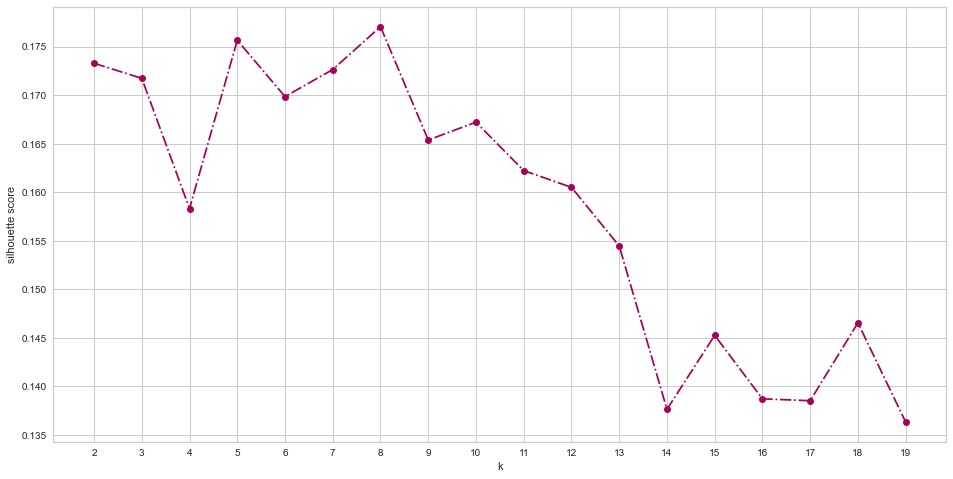

In [19]:
# searching for the best number of clusters
k_number_2 =  best_k(X_prep_2, range(2, 20))

In [20]:
# using 8 clusters
clusters_2, result_df2 = k_clustering(X_prep_2, data, 8)
result_df2.head()

0    145
1    256
2    627
3    537
4    626
5    190
6    533
7    283
dtype: int64
23635.966288896903


,name,style,brewery,beer_name_(full),description,abv,min_ibu,max_ibu,astringency,body,...,spices,malty,review_aroma,review_appearance,review_palate,review_taste,review_overall,number_of_reviews,weighted_rating,cluster
0,Amber,Altbier,Alaskan Brewing Co.,Alaskan Brewing Co. Alaskan Amber,"Notes:Richly malty and long on the palate, wit...",5.3,25,50,13,32,...,8,111,3.498994,3.636821,3.556338,3.643863,3.847082,497,3.815278,4
1,Double Bag,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Double Bag,"Notes:This malty, full-bodied double alt is al...",7.2,25,50,12,57,...,12,84,3.798337,3.846154,3.904366,4.024948,4.034304,481,3.940641,4
2,Long Trail Ale,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Long Trail Ale,Notes:Long Trail Ale is a full-bodied amber al...,5.0,25,50,14,37,...,4,62,3.409814,3.667109,3.600796,3.631300,3.830239,377,3.798620,3
3,Doppelsticke,Altbier,Uerige Obergärige Hausbrauerei GmbH / Zum Uerige,Uerige Obergärige Hausbrauerei GmbH / Zum Ueri...,Notes:,8.5,25,50,13,55,...,16,119,4.148098,4.033967,4.150815,4.205163,4.005435,368,3.905371,4
4,Sleigh'r Dark Doüble Alt Ale,Altbier,Ninkasi Brewing Company,Ninkasi Brewing Company Sleigh'r Dark Doüble A...,Notes:Called 'Dark Double Alt' on the label.Se...,7.2,25,50,25,51,...,20,95,3.625000,3.973958,3.734375,3.765625,3.817708,96,3.767984,4


Looking at the Silhouette Visualizer, the optimal k number could also be 3, 5 and 10. Let's also visualize with these k numbers to make a comparison. 

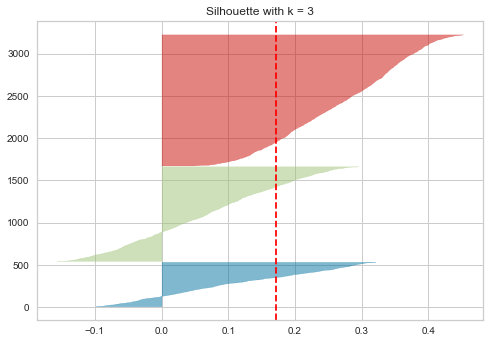

In [21]:
silhouette_viz = silhouette(X_prep_2, 3)
# 3rd cluster is too big

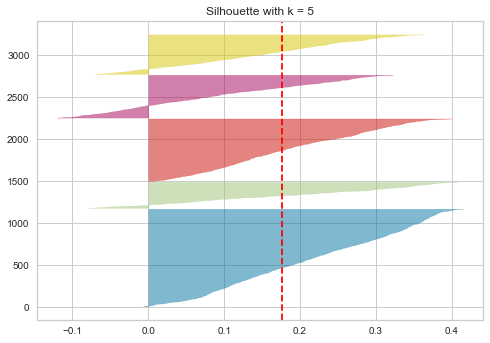

In [22]:
silhouette_viz = silhouette(X_prep_2, 5)
# 3rd cluster is too big

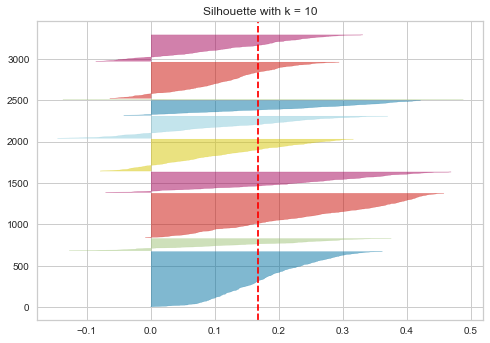

In [23]:
silhouette_viz = silhouette(X_prep_2, 10)
# too many small ones

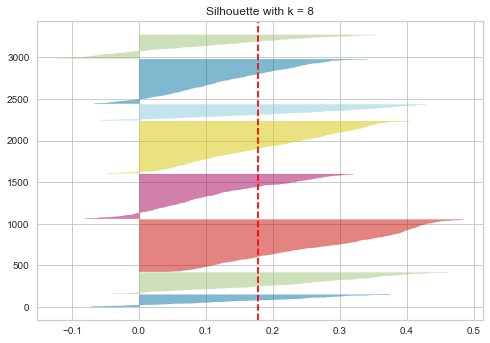

In [24]:
silhouette_viz = silhouette(X_prep_2, 8)
# it's more imbalanced than with X_prep_1 so we will keep the original `style` column fo clustering

#### Visualizing the 8 clusters

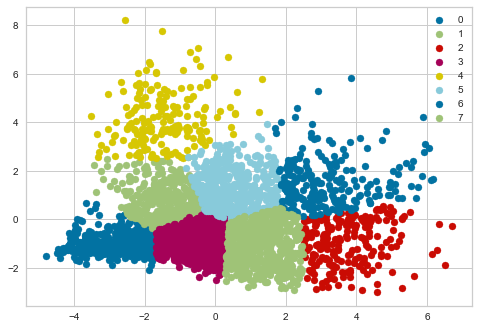

In [25]:
## Transform the data into 2D so we can see
pca = PCA(2) 
X_2D = pca.fit_transform(X_prep_2)

# Predicting the clusters with k = 8
kmeans_8 = KMeans(n_clusters=8, random_state=42)
kmeans_8.fit(X_2D)
clusters_ = kmeans_8.predict(X_2D)


labels = np.unique(clusters_)

for i in labels:
    plt.scatter(X_2D[clusters_ == i , 0] , X_2D[clusters_ == i , 1] , label = i)
plt.legend()
plt.show()

### Exploring the clusters

In [26]:
result_df2[result_df2['cluster'] == 1]['style'].unique()

array(['Barleywine - American',
       'Bitter - English Extra Special / Strong Bitter (ESB)',
       'Bock - Maibock', 'IPA - American', 'IPA - Belgian',
       'IPA - Black / Cascadian Dark Ale', 'IPA - English',
       'IPA - Imperial', 'IPA - New England',
       'Lager - India Pale Lager (IPL)', 'Pale Ale - American',
       'Pilsner - Imperial', 'Red Ale - American Amber / Red',
       'Red Ale - Imperial', 'Rye Beer', 'Stout - American Imperial',
       'Stout - Russian Imperial', 'Strong Ale - American',
       'Strong Ale - English', 'Winter Warmer'], dtype=object)

## III. Building the recommender

#### Preparing the dataframe that will be used by the recommender

In [27]:
# creating a copy
df_rec = result_df2.copy()

# adding the main_style and substyle columns
df_rec = pd.concat([df_rec, styles], axis=1)
df_rec.head()

,name,style,brewery,beer_name_(full),description,abv,min_ibu,max_ibu,astringency,body,...,review_aroma,review_appearance,review_palate,review_taste,review_overall,number_of_reviews,weighted_rating,cluster,main_style,substyle
0,Amber,Altbier,Alaskan Brewing Co.,Alaskan Brewing Co. Alaskan Amber,"Notes:Richly malty and long on the palate, wit...",5.3,25,50,13,32,...,3.498994,3.636821,3.556338,3.643863,3.847082,497,3.815278,4,Brown Ale,Altbier
1,Double Bag,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Double Bag,"Notes:This malty, full-bodied double alt is al...",7.2,25,50,12,57,...,3.798337,3.846154,3.904366,4.024948,4.034304,481,3.940641,4,Brown Ale,Altbier
2,Long Trail Ale,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Long Trail Ale,Notes:Long Trail Ale is a full-bodied amber al...,5.0,25,50,14,37,...,3.409814,3.667109,3.600796,3.631300,3.830239,377,3.798620,3,Brown Ale,Altbier
3,Doppelsticke,Altbier,Uerige Obergärige Hausbrauerei GmbH / Zum Uerige,Uerige Obergärige Hausbrauerei GmbH / Zum Ueri...,Notes:,8.5,25,50,13,55,...,4.148098,4.033967,4.150815,4.205163,4.005435,368,3.905371,4,Brown Ale,Altbier
4,Sleigh'r Dark Doüble Alt Ale,Altbier,Ninkasi Brewing Company,Ninkasi Brewing Company Sleigh'r Dark Doüble A...,Notes:Called 'Dark Double Alt' on the label.Se...,7.2,25,50,25,51,...,3.625000,3.973958,3.734375,3.765625,3.817708,96,3.767984,4,Brown Ale,Altbier


#### Creating a list of German beers
There are a lot of German beers which are not labeled 'German' as the English and American beers are.\
This list can then be used to filter the dataframe if the user asks for a German beer.

In [28]:
german_beers = ['Altbier', 'Doppelbock', 'Eisbock', 'Maibock', 'Weizenbock', 'Kölsch', 'Helles', 'Kellerbier / Zwickelbier',
               'Munich Dunkel', 'Märzen / Oktoberfest', 'Rauchbier', 'Schwarzbier', 'German', 'Berliner Weisse',
               'Dunkelweizen', 'Hefeweizen', 'Kristallweizen']

#### Creating the function that will take an input and recommend a beer based on that input

In [203]:
def find_the_right_beer():
    
    ''' FUNCTIONS FOR STRING MANIPULATION '''  
    
    # function to format the string: all lowercase, removing spaces or special characters, and the words 'beer' and 'ale'
    format_ = lambda x: x.lower().strip().replace('beer', '').replace('ale', ' ').replace('-', '').replace('/', '').replace(' ', '')
    # same function but without replacing 'beer' or 'ale'
    format_2 = lambda x: x.lower().strip().replace('-', '').replace('/', '').replace(' ', '')
    # function for reversing the string: in the dataset the logical order is 'beer - location' (ex: IPA - American)
    # but it is more natural for a user to type 'American IPA'
    reverse_ = lambda x: ''.join(list(reversed(x.split())))
    
    
    ''' ASKING THE USER FOR INPUT ''' 
    
    message = 'What kind of beer would you like? Please pick a beer or a beer style: '
    request = input(message)
    
    # getting the word count
    word_count = len(request.split())
    
    # removing spaces and special characters
    beer = format_(request)
        
        
    ''' UNDERSTANDING THE NATURE OF THE INPUT '''  
    
    # Checking if the input is a beer name, a brewery name or a beer style
    
    # The filt value will determine if we have a useable input or if we need to ask the user for input again
    filt = 'not found'
    
    # we will keep asking for input as long as the input is not useable, ie. found in the dataframe
    while filt == 'not found':
        
        # 1st search - with the first search, we first look if the input can be found in only one column
        # does it match a MAIN STYLE?
        for value in df_rec['main_style']:
            original_value = value
            val_0 = format_(value)
            val_0_r = format_(reverse_(value))
            if beer in [val_0, val_0_r]:
                filt = 'main_style'
                val = original_value
                break
            else:
                filt = 'not found'
         
        if filt == 'main_style':
            break
        
        # does it match a SUBSTYLE?
        if filt == 'not found':
            for value in df_rec['substyle']:
                original_value = value
                val_1 = format_(value)
                val_1_r = format_(reverse_(value))
                if beer in [val_1, val_1_r]:
                    filt = 'substyle'
                    val = original_value
                    break
                else:
                    filt = 'not found'

        if filt == 'substyle':
            break
            
        # does it match a STYLE?
        if filt == 'not found':
            # getting all the permutations of word order
            w_list = request.split()
            perms = list(permutations(w_list))
            perms_ = [''.join(p).lower().replace('-', '').replace('/', '') for p in perms] 
            filt = []
            val = []
            for p in perms_:
                for value in df_rec['style']:
                    original_value = value
                    val_2 = format_2(value)
                    if p == val_2:
                        filt.append('style')
                        val.append(original_value)
                        break
        if filt == []:
            filt = 'not found'
        else:
            filt = filt[0]
            print(filt)


        if filt == 'style':
            break 
        
        # 2nd search - with the second search, we look if each word in the input can be found in a different column
        if filt == 'not found' and word_count == 2:
        
            word_list = (list(request.split()))  
            
            filt = []
            val = []
                    
            for word in word_list:
                         
                # does it match a MAIN STYLE?
                for value in df_rec['main_style']:
                    original_value = value
                    val_0 = format_(value)
                    val_0_r = format_(reverse_(value))
                    if word in [val_0, val_0_r]:
                        filt_a = 'main_style'
                        val_a = original_value
                        filt.append(filt_a)
                        val.append(val_a)
                        break

                # does it match a SUBSTYLE?
                for value in df_rec['substyle']:
                    original_value = value
                    val_1 = format_(value)
                    val_1_r = format_(reverse_(value))
                    if word in [val_1, val_1_r]:
                        filt_b = 'substyle'
                        val_b = original_value
                        filt.append(filt_b)
                        val.append(val_b)
                        break    
                        
        if filt == []:
            filt = 'not found'      
        
                
        # 3rd search - we check if the input can be found in a the beer_name_(full) column or brewery column
        # it's the last search because it would mean the input is the most detailed
        if filt == 'not found':
            for value in df_rec['beer_name_(full)']:
                original_value = value
                val_2 = format_(value)
                if beer in val_2:
                    filt = 'beer_name_(full)'
                    val = original_value
                    break
                else:
                    filt = 'not found'
        
        if filt == 'not found':
            for value in df_rec['brewery']:
                original_value = value
                val_2 = format_(value)
                if beer in val_2:
                    filt = 'brewery'
                    val = original_value
                    break
                else:
                    filt = 'not found'
        
        # if there is still no match, then we ask the user for input again and re-run the loop
        if filt == 'not found':
            print('Sorry, we cannot find any match for this query. Lots of craft beers in there.')
            print(filt)
            request = input(message)
            beer = format_(request)
            word_count = len(request.split())
    

    ''' FILTERING THE DATAFRAME BASED ON THE INPUT ''' 
    
    # filtering the dataframe based on the value found in the 1st or 3rd search
    if str(type(val)) != "<class 'list'>":
        df_subset = df_rec[df_rec[filt].str.startswith(val)]
    # if the filter is `style`, the value is in a list
    elif filt == 'style':
        df_subset = df_rec[df_rec[filt].str.startswith(val[0])]
    
    # filtering the dataframe based on the value found in the 2nd search
    # if the second search only returned one value
    elif len(val) == 1:
        df_subset = df_rec[df_rec[filt[0]].str.startswith(val[0])]
    # if the two values returned by the second search are from the same column (ex: two substyles)
    elif filt[0] == filt[1]:
        df_subset = df_rec[(df_rec[filt[0]].str.startswith(val[0])) | (df_rec[filt[1]].str.startswith(val[1]))]
    # if the second search returned one value from the `main_style` column and one value from the `substyle`column
    else:
        df_subset = df_rec[(df_rec[filt[0]].str.startswith(val[0])) & (df_rec[filt[1]].str.startswith(val[1]))]
        # checking if dataframe is empty
        # it's possible that the `main_style` and `substyle` exist but don't describe the same beer
        if df_subset.shape[0] == 0:
            df_subset = df_rec[(df_rec[filt[0]].str.startswith(val[0])) | (df_rec[filt[1]].str.startswith(val[1]))]
           
        
    ''' RECOMMENDING A BEER ''' 
    
    # the recommendation will work differently depending on the nature of the input
        
        
    ''' RECOMMENDING BASED ON A BEER STYLE '''
    # if the input is a style we will find the cluster to find similar beers
    if filt != 'beer_name_(full)':
        
        # getting the list of clusters the beer style belongs to
        # a beer style can be wide ranging enough to have outliers that will belong to another cluster
        clusters = dict(df_subset['cluster'].value_counts())
        # so we need to find the cluster that has the most values
        cluster = max(clusters, key = clusters.get)

        # filtering by cluster
        df_cluster = df_subset[df_subset['cluster'] == cluster]
        
        # finding 5 beers with the highest weighted rating in this cluster                                     
        top_5 = df_cluster.sort_values('weighted_rating', ascending=False).head(5)
        
        # recommending the 5 beers to the user
        for row in range(0, 5):
            print(f'{row + 1}#:', top_5.iloc[row]['name'], 'from', top_5.iloc[row]['brewery'], ',', top_5.iloc[row]['style'], 
                  'beer with an overall review of', round(top_5.iloc[row]['review_overall'],2), '.')
    
    
    ''' RECOMMENDING BASED ON A BEER OR BREWERY NAME '''
    # if the input is a beer name we will find the beer's cluster and then the 5 closest beers within this cluster
    else:
        # finding the cluster
        cluster = df_subset['cluster'].unique()
        
        # filtering the dataframe based on the cluster
        df_cluster = df_rec[(df_rec['cluster'] == cluster[0]) & (df_rec['beer_name_(full)'] != val)]
        
        # scaling the cluster and the subset
        scaler = StandardScaler().fit(df_rec[features_])
        scaled_cluster = scaler.transform(df_cluster[features_])
        X_cluster = pd.DataFrame(scaled_cluster)
        X_cluster.columns = features_
        scaled_subset = scaler.transform(df_subset[features_])
        X_subset = pd.DataFrame(scaled_subset)
        X_subset.columns = features_
        
        # predicting the 5 closest beers within the cluster - KNN
        model_knn = NearestNeighbors(algorithm='ball_tree', n_neighbors=6, n_jobs=None).fit(X_cluster)
        predictions = model_knn.kneighbors(X_subset, return_distance=False)
        
        # top 5 beers
        top_5 = df_rec.loc[predictions[0][1:]]
        top_5 = top_5.sort_values('weighted_rating', ascending=False)
        
        # recommending the 5 beers to the user
        for row in range(0, 5):
            print(f'{row + 1}#:', top_5.iloc[row]['name'], 'from', top_5.iloc[row]['brewery'], ',', top_5.iloc[row]['style'], 
                  'beer with an overall review of', round(top_5.iloc[row]['review_overall'],2), 
                  'by', top_5.iloc[row]['number_of_reviews'],'users.')
    

In [208]:
rec = find_the_right_beer()

What kind of beer would you like? Please pick a beer or a beer style: german blonde
1#: Prima Pils from Victory Brewing Company , Pilsner - German beer with an overall review of 4.24 .
2#: Trappist Westvleteren BlondBrouwerij Westvleteren (Sint-Sixtusabdij van Westvleteren) from Brouwerij Westvleteren (Sint-Sixtusabdij van Westvleteren) , Blonde Ale - Belgian beer with an overall review of 4.37 .
3#: Samuel Adams Noble PilsBoston Beer Company (Samuel Adams) from Boston Beer Company (Samuel Adams) , Pilsner - German beer with an overall review of 4.12 .
4#: Pikeland Pils from Sly Fox Brewing Company , Pilsner - German beer with an overall review of 4.14 .
5#: Sunshine Pils from Tröegs Brewing Company , Pilsner - German beer with an overall review of 4.06 .
